In [1]:
using AA222
using PyPlot
using Distributions

Loading help data...


# Gaussian Processes

In [2]:
function meanVector(X, m::Function)
    n = size(X,2)
    mu = zeros(n)
    for i = 1:n
        mu[i] = m(X[:,i])
    end
    return mu
end

meanVector (generic function with 1 method)

In [3]:
function zeroMean()
    x -> 0
end

zeroMean (generic function with 1 method)

There are many kinds of kernel functions:  
Constant: $\sigma_0^2$  
Linear: $\sum_{d=1}^D \sigma_d^2 x_d x'd$  
Polynomial: $(x^\top x' + \sigma_0^2)^p$  
Squared exponential: $\exp(-\frac{r^2}{2\ell^2})$  
Matern: $\frac{1}{2^{\nu-1}\Gamma(\nu)}\left(\frac{\sqrt{2\nu}}{\ell}r\right)^\nu K_\nu\left(\frac{\sqrt{2\nu}}{\ell}r \right)$  
Exponential: $\exp(-\frac{r}{\ell})$  
$\gamma$-exponential: $\exp(-\frac{r}{\ell})$  
Rational quadratic: $(1 + \frac{r^2}{2\alpha\ell^2})^{-\alpha}$  
Neural network: $\sin^{-1}\left(\frac{2\bar x^\top \Sigma \bar x'}{\sqrt{(1+2\bar x^\top \Sigma \bar x)(1+2\bar x'^\top \Sigma \bar x')}} \right)$ where $\bar x$ is the augmented input vector $[1, x_1, \ldots, x_d]$  
see Table 4.1 in http://www.gaussianprocess.org/gpml/chapters/RW4.pdf 

In [4]:
function covMatrix(X, Y, k::Function)
    n = size(X,2)
    m = size(Y,2)
    Sigma = zeros(n, m)
    for i = 1:n
        for j = 1:m
            Sigma[i,j] = k(X[:,i], Y[:,j])
        end
    end
    return Sigma
end

covMatrix (generic function with 1 method)

In [5]:
# add a little inflation to avoid numerical issues (non-PSD)
function mvnrand(mu, Sigma, inflation = 1e-6)
    Y = rand(MvNormal(mu, Sigma + inflation .* eye(length(mu))))
end

mvnrand (generic function with 2 methods)

In [6]:
function squaredExponential(xi, xj, characteristicLengthScale = 1)
    exp(-(norm(xi - xj)/characteristicLengthScale)^2)
end

squaredExponential (generic function with 2 methods)

In [7]:
function squaredExponential(characteristicLengthScale = 1)
    return (xi,xj) -> squaredExponential(xi, xj, characteristicLengthScale)
end

squaredExponential (generic function with 4 methods)

In [8]:
function sampleGP(X, m::Function, k::Function)
    Sigma = covMatrix(X, X, k)
    mu = meanVector(X, m)
    Y = mvnrand(mu, Sigma)
end

sampleGP (generic function with 1 method)

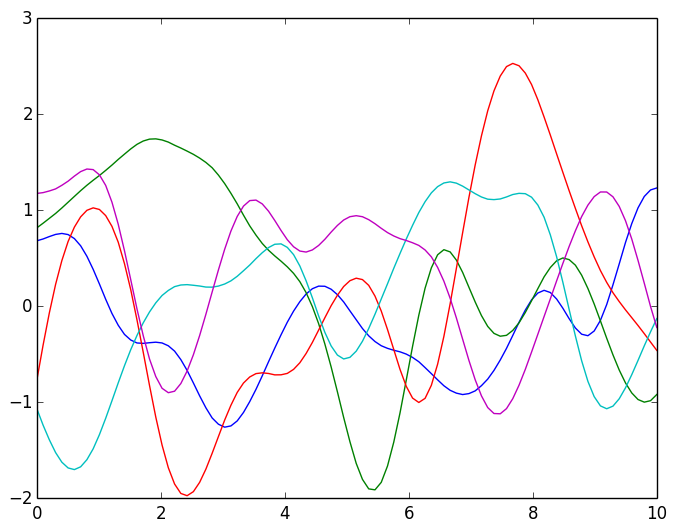

In [9]:
X = linspace(0,10)'
for i = 1:5
    Y = sampleGP(X, zeroMean(), squaredExponential())
    plot(squeeze(X,1), Y)
end

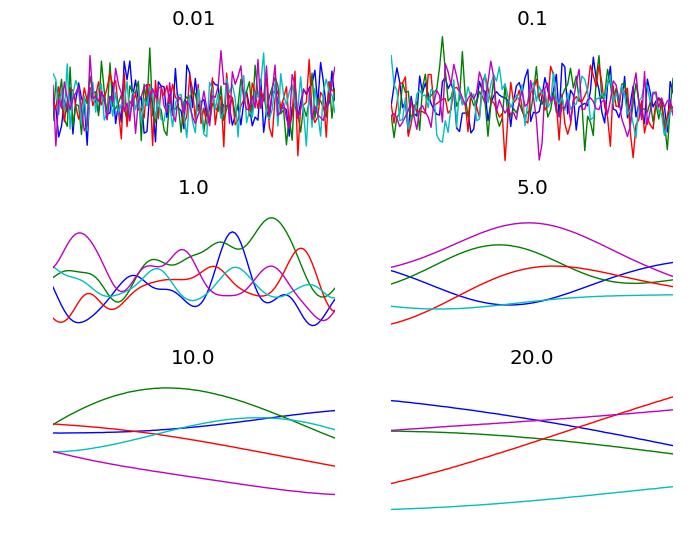

In [10]:
# Examples of different characteristic length scales
ell = [0.01 0.1 1 5 10 20]
for i = 1:length(ell)
    subplot(3,2,i)
    for j = 1:5
        Y = sampleGP(X, zeroMean(), squaredExponential(ell[i]))
        plot(squeeze(X,1), Y)  
        axis("off")
        title(ell[i])
    end
end

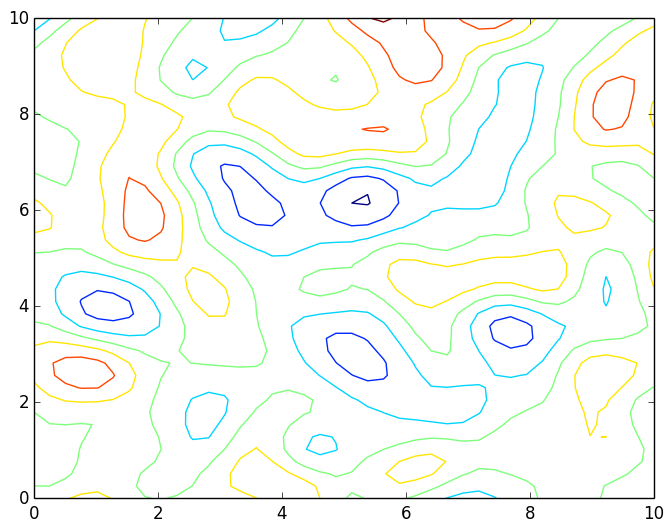

In [10]:
# 2D Gaussian Process
(x,y) = meshgrid(linspace(0,10,40), linspace(0,10,40))
X = [x[:]'; y[:]']
Y = sampleGP(X, zeroMean(), squaredExponential())
contour(x,y,reshape(Y,size(x)));

# Prediction

In [11]:
function predict(Xtrain, Ytrain, Xpred, k::Function)
    K = (X, Y) -> covMatrix(X, Y, k)
    tmp = K(Xpred, Xtrain) * inv(K(Xtrain, Xtrain))
    mu = tmp * Ytrain
    S = K(Xpred, Xpred) - tmp * K(Xtrain, Xpred)
    sd = sqrt(diag(S)+eps()) # add a small eps to prevent numerical issues
    return mu, sd
end

predict (generic function with 1 method)

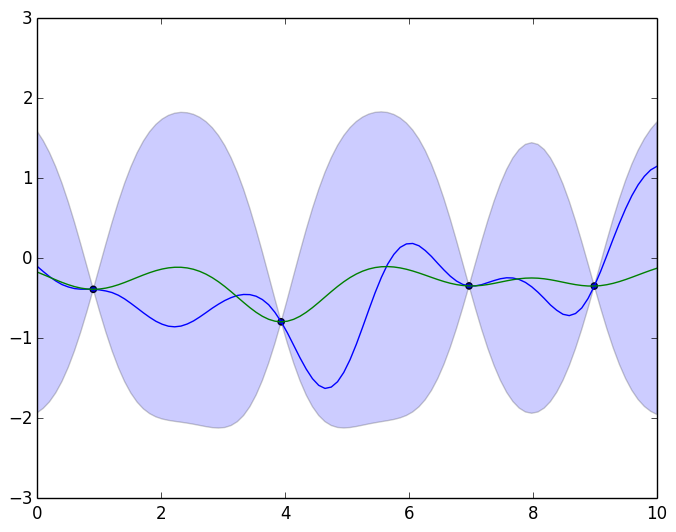

In [11]:
# create random "true" function
X = linspace(0,10)'
Y = sampleGP(X, zeroMean(), squaredExponential())
plot(squeeze(X,1), Y)
xlim(0,10)

# create training set
trainIndex = [10, 40, 70, 90]
Xtrain = X[:,trainIndex]
Ytrain = Y[trainIndex]
scatter(Xtrain, Ytrain)

# predict
(mu, sd) = predict(Xtrain, Ytrain, X, squaredExponential())
plot(squeeze(X,1), mu)
upperConfidence = mu .+ 1.96 * sd
lowerConfidence = mu .- 1.96 * sd
fill_between(squeeze(X,1), upperConfidence, lowerConfidence, alpha="0.2");

In [12]:
# assume y = f(x) + eps where eps ~ N(0,sigma^2)
function predict(Xtrain, Ytrain, Xpred, k::Function, sigma::Real = 0)
    K = (X, Y) -> covMatrix(X, Y, k)
    tmp = K(Xpred, Xtrain) * inv(K(Xtrain, Xtrain) + sigma^2 .* eye(length(Xtrain)))
    mu = tmp * Ytrain
    S = K(Xpred, Xpred) - tmp * K(Xtrain, Xpred)
    sd = sqrt(diag(S) .+ eps())
    return mu, sd
end

predict (generic function with 2 methods)

In [28]:
function plotPredict(Xtrain, Ytrain, X, k, sigma::Real = 0)
    (mu, sd) = predict(Xtrain, Ytrain, X, k, sigma)
    plot(squeeze(X,1), mu)
    upperConfidence = mu .+ 1.96 * sd
    lowerConfidence = mu .- 1.96 * sd
    fill_between(squeeze(X,1), upperConfidence, lowerConfidence, alpha="0.2");    
    return (mu, sd)
end

plotPredict (generic function with 2 methods)

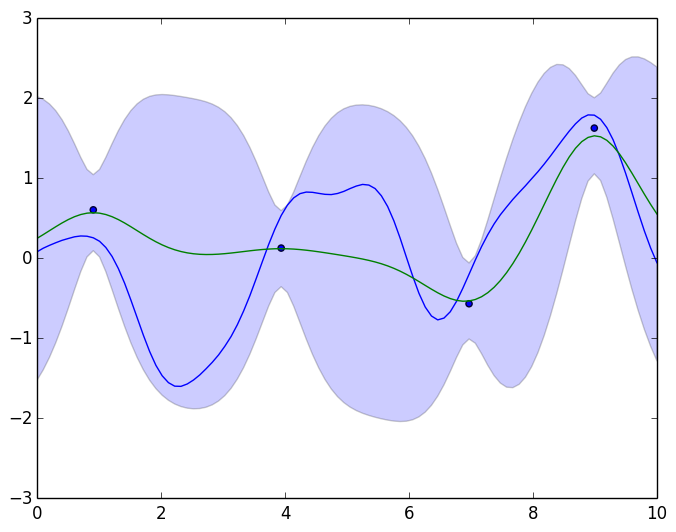

In [13]:
# noise parameter
sigmaNoise = 0.25

# create random "true" function
X = linspace(0,10)'
Y = sampleGP(X, zeroMean(), squaredExponential())
plot(squeeze(X,1), Y)
xlim(0,10)

# create training set
trainIndex = [10, 40, 70, 90]
Xtrain = X[:,trainIndex]
Ytrain = Y[trainIndex] + randn(length(trainIndex)) * sigmaNoise
scatter(Xtrain, Ytrain)

# predict
plotPredict(Xtrain, Ytrain, X, squaredExponential(), sigmaNoise);

# Log Marginal Likelihood

$$\log p(\vec y \mid X) = -\frac12 \vec y^\top(K + \sigma_n^2 I)^{-1}\vec y - \frac12 \log |K + \sigma_n^2I| - \frac{n}2 \log 2 \pi$$

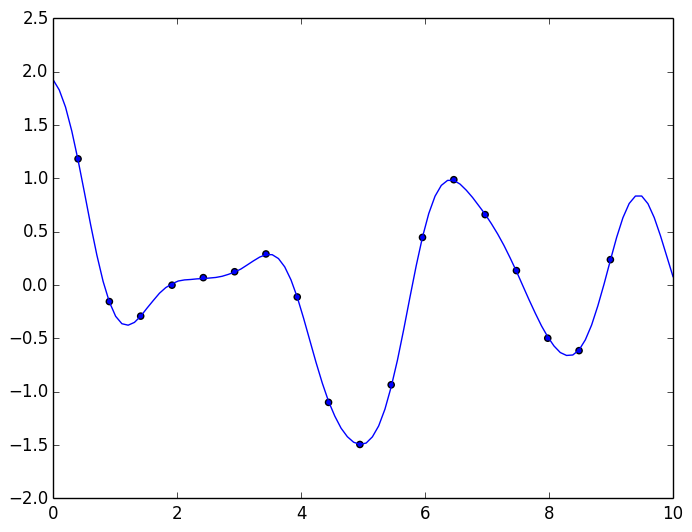

In [13]:
# noise parameter
sigmaNoise = 1e-2

# create random "true" function
X = linspace(0,10)'
Y = sampleGP(X, zeroMean(), squaredExponential())
plot(squeeze(X,1), Y)
xlim(0,10)

# create training set
trainIndex = 5:5:90
Xtrain = X[:,trainIndex]
Ytrain = Y[trainIndex] + randn(length(trainIndex)) * sigmaNoise
scatter(Xtrain, Ytrain);

In [14]:
# see equation (2.30) from http://www.gaussianprocess.org/gpml/chapters/RW2.pdf
function logMarginal(y, X, k::Function, sigma::Real)
    n = length(y)
    tmp = covMatrix(X,X,k) + sigma^2 * eye(n)
    -(1/2)*dot(y, inv(tmp)*y) - (1/2)*log(det(tmp)) - (n/2)*log(2*pi)
end

logMarginal (generic function with 1 method)

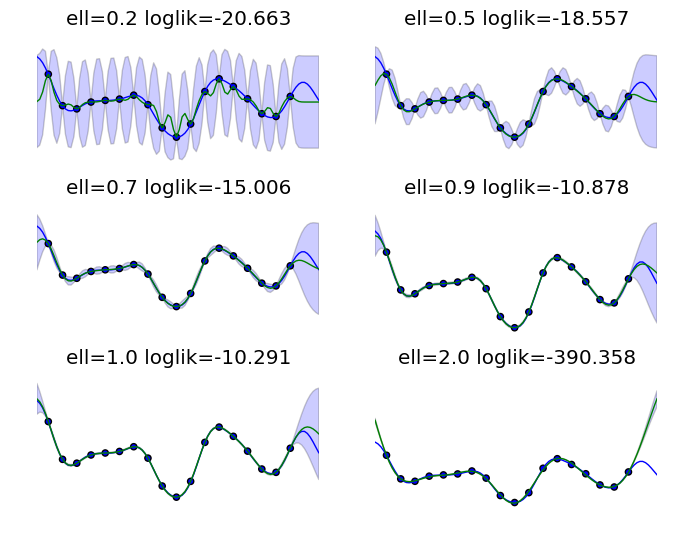

In [15]:
ell = [0.2 0.5 0.7 0.9 1 2]
for i = 1:length(ell)
    subplot(3,2,i)
    plot(squeeze(X,1), Y)
    xlim(0,10)
    axis("off")
    plotPredict(Xtrain, Ytrain, X, squaredExponential(ell[i]), sigmaNoise)
    scatter(Xtrain, Ytrain)
    loglik = logMarginal(Ytrain, Xtrain, squaredExponential(ell[i]), sigmaNoise)
    title(@sprintf("ell=%.1f loglik=%.3f", ell[i], loglik))
end

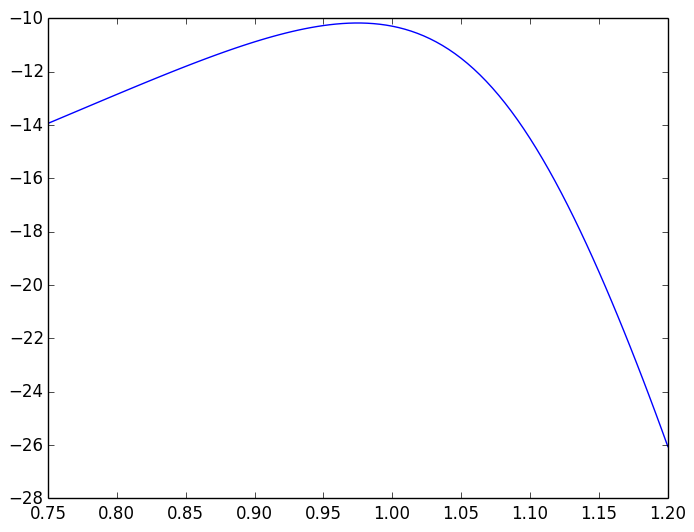

In [15]:
xdom(0.75, 1.2)
f(ell) = logMarginal(Ytrain, Xtrain, squaredExponential(ell), sigmaNoise)
plot(f);

In [16]:
# see Alg. 2.1 from http://www.gaussianprocess.org/gpml/chapters/RW2.pdf
# Can be faster by using the Cholesky decomposition
function predictFast(Xtrain, Ytrain, Xpred, k::Function, sigma::Real = 0)
    K = (X, Y) -> covMatrix(X, Y, k)
    n = size(Xtrain, 2)
    L = chol(K(Xtrain, Xtrain) + sigma^2 * eye(n))'
    alpha = L' \ (L \ Ytrain)
    kstar = K(Xtrain, Xpred)
    mu = (kstar' * alpha)
    v = L \ kstar
    V = K(Xpred, Xpred) - v' * v
    loglik = -(1/2)dot(Ytrain, alpha) - sum(log(diag(L))) - (n/2)*log(2*pi)
    sd = sqrt(diag(V) .+ eps())
    return (mu, sd, loglik)
end

predictFast (generic function with 2 methods)

# Prediction-Based Optimization

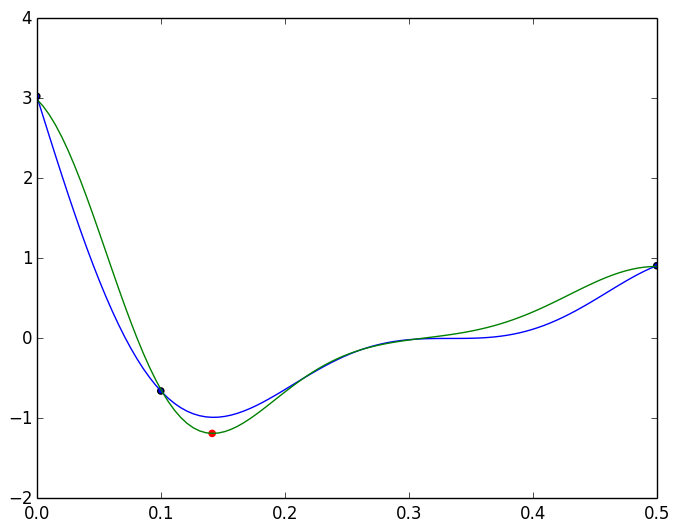

In [16]:
# Example from EDSM Sec. 3.2.1
f(x) = (6x - 2)^2 * sin(12x - 4)
xdom(0,0.5)
plot(f);
# generate training data
Xtrain = [0 0.1 0.5]
Ytrain = squeeze(map(f, Xtrain), 1)
scatter(Xtrain, Ytrain)
# predict
Xpred = linspace(0,0.5)'
(mu, sd) = predict(Xtrain, Ytrain, Xpred, squaredExponential(0.1), 1e-1)
plot(Xpred', mu);
# find minimum
i = indmin(mu)
scatter(Xpred[i], mu[i], color = "red");

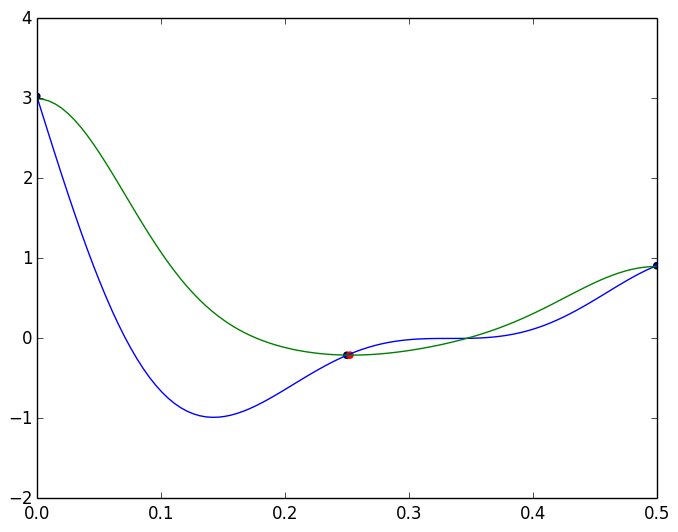

In [16]:
# Example from EDSM Sec. 3.2.1
f(x) = (6x - 2)^2 * sin(12x - 4)
xdom(0,0.5)
plot(f);
# generate training data
Xtrain = [0 0.25 0.5]
Ytrain = squeeze(map(f, Xtrain), 1)
scatter(Xtrain, Ytrain)
# predict
Xpred = linspace(0,0.5)'
(mu, sd) = predict(Xtrain, Ytrain, Xpred, squaredExponential(0.1), 1e-1)
plot(Xpred', mu);
# find minimum
i = indmin(mu)
scatter(Xpred[i], mu[i], color = "red");

Clearly, using the mean prediction to select the next point does not always work

# Error-Based Exploration

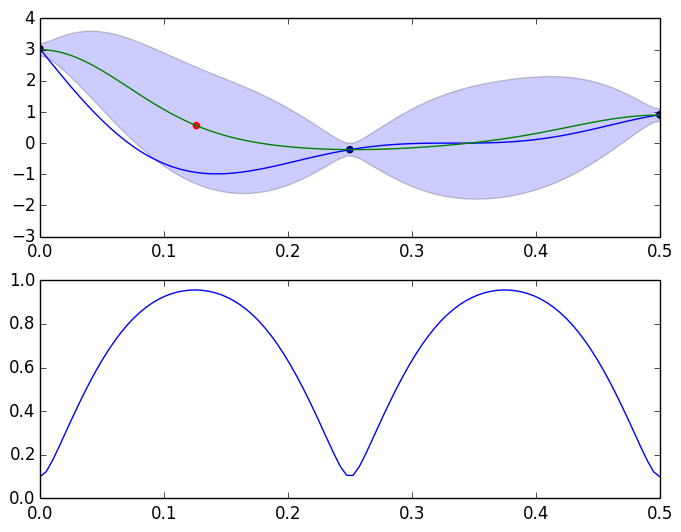

In [27]:
subplot(2,1,1)
f(x) = (6x - 2)^2 * sin(12x - 4)
xdom(0,0.5)
plot(f);
# generate training data
Xtrain = [0 0.25 0.5]
Ytrain = squeeze(map(f, Xtrain), 1)
scatter(Xtrain, Ytrain)
# predict
Xpred = linspace(0,0.5)'
(mu, sd) = plotPredict(Xtrain, Ytrain, Xpred, squaredExponential(0.1), 1e-1)
# find minimum
i = indmax(sd)
scatter(Xpred[i], mu[i], color = "red");

# plot sd
subplot(2,1,2)
plot(Xpred', sd)
xlim(0,0.5);

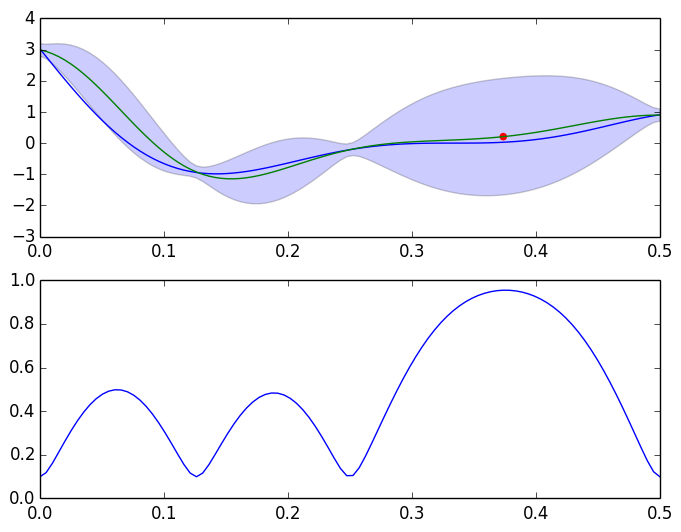

In [27]:
subplot(2,1,1)
plot(f)
Xtrain = hcat(Xtrain, Xpred[i]) # add point to training set
Ytrain = squeeze(map(f, Xtrain), 1)
# predict
(mu, sd) = plotPredict(Xtrain, Ytrain, Xpred, squaredExponential(0.1), 1e-1)
# find minimum
i = indmax(sd)
scatter(Xpred[i], mu[i], color = "red");

# plot sd
subplot(2,1,2)
plot(Xpred', sd)
xlim(0,0.5);

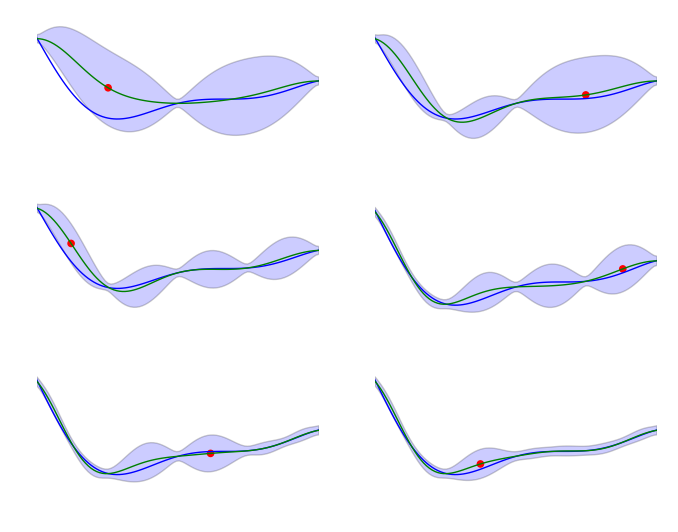

In [30]:
Xtrain = [0 0.25 0.5]
for i = 1:6
    Ytrain = squeeze(map(f, Xtrain), 1)
    subplot(3,2,i)
    plot(f)
    (mu, sd) = plotPredict(Xtrain, Ytrain, Xpred, squaredExponential(0.1), 1e-1)
    i = indmax(sd)
    scatter(Xpred[i], mu[i], color = "red")
    Xtrain = hcat(Xtrain, Xpred[i]) # add point to training set
    axis("off")
end

# Statistical Lower Bound Exploration

$LB(x) = \hat y(s) - A\hat s(x)$  
where $A$ is the a constant that controls the exploration / exploitation balance (using notation from EDSM p. 86).  
What are the properties as $A \rightarrow 0$ and $A \rightarrow \infty$?

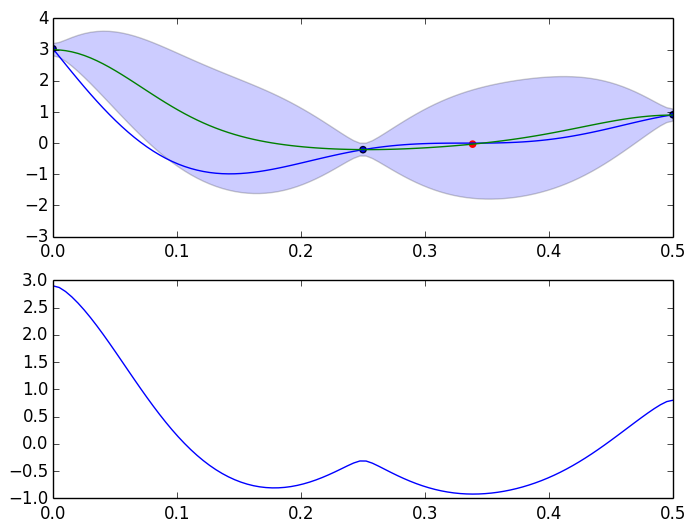

In [30]:
A = 1

subplot(2,1,1)
f(x) = (6x - 2)^2 * sin(12x - 4)
xdom(0,0.5)
plot(f);
# generate training data
Xtrain = [0 0.25 0.5]
Ytrain = squeeze(map(f, Xtrain), 1)
scatter(Xtrain, Ytrain)
# predict
Xpred = linspace(0,0.5)'
(mu, sd) = plotPredict(Xtrain, Ytrain, Xpred, squaredExponential(0.1), 1e-1)
# find minimum
i = indmin(mu - A * sd)
scatter(Xpred[i], mu[i], color = "red");

# plot mu + A * sd
subplot(2,1,2)
plot(Xpred', mu - A * sd)
xlim(0,0.5);

# Probability of Improvement

Probability of improvement:
$$\Phi\left( \frac{y_{min} - \hat y(x)}{\hat s(x)} \right) = \frac12 + \frac12 \text{erf}\left( \frac{y_{min} - \hat y(x)}{\sqrt{2} \hat s(x)} \right)$$
(see EDSM p. 88)

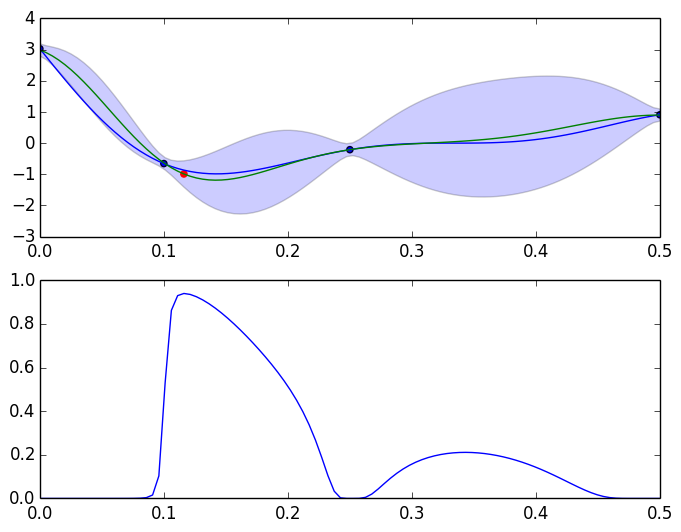

In [30]:
A = 1

subplot(2,1,1)
f(x) = (6x - 2)^2 * sin(12x - 4)
xdom(0,0.5)
plot(f);
# generate training data
Xtrain = [0 0.1 0.25 0.5]
Ytrain = squeeze(map(f, Xtrain), 1)
scatter(Xtrain, Ytrain)
# predict
Xpred = linspace(0,0.5)'
(mu, sd) = plotPredict(Xtrain, Ytrain, Xpred, squaredExponential(0.1), 1e-1)
# find minimum
ymin = minimum(Ytrain)
probImprovement = 0.5 + 0.5 * erf((ymin - mu)./(sqrt(2)*sd))
i = indmax(probImprovement)
scatter(Xpred[i], mu[i], color = "red");

# plot mu + A * sd
subplot(2,1,2)
plot(Xpred', probImprovement)
xlim(0,0.5);

# Expected Improvement

$E[\max\{y_{min} - Y, 0\}] = (y_{min} - \hat y(x)) \Phi\left( \frac{y_{min} - \hat y(x)}{\hat s(x)} \right) + \hat s(x) \phi\left( \frac{y_{min} - \hat y(x)}{\hat s(x)} \right)$

In [31]:
Phi(x) = 0.5 + 0.5 * erf(x ./ sqrt(2))
phi(x) = exp(-0.5 * x.^2) / sqrt(2 * pi);

In [32]:
function expectedImprovement(ymin, mu, sd)
    tmp = (ymin - mu)./sd
    (ymin - mu) .* Phi(tmp) + sd .* phi(tmp)
end;

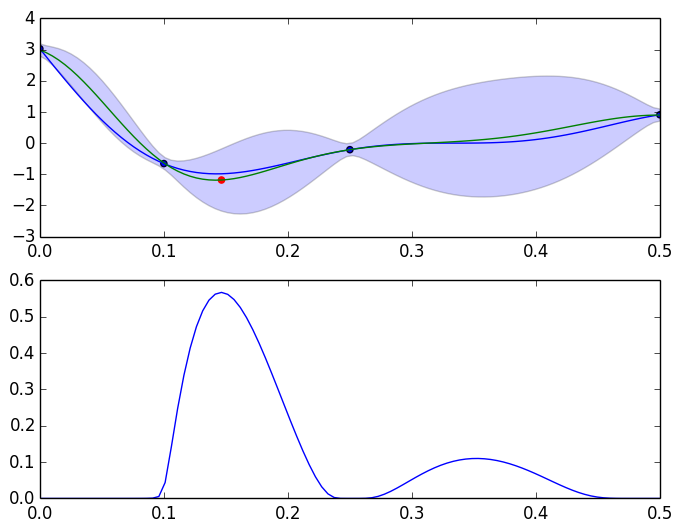

In [32]:
A = 1

subplot(2,1,1)
f(x) = (6x - 2)^2 * sin(12x - 4)
xdom(0,0.5)
plot(f);
# generate training data
Xtrain = [0 0.1 0.25 0.5]
Ytrain = squeeze(map(f, Xtrain), 1)
scatter(Xtrain, Ytrain)
# predict
Xpred = linspace(0,0.5)'
(mu, sd) = plotPredict(Xtrain, Ytrain, Xpred, squaredExponential(0.1), 1e-1)
# find minimum
ymin = minimum(Ytrain)
expImprovement = expectedImprovement(ymin, mu, sd)
i = indmax(expImprovement)
scatter(Xpred[i], mu[i], color = "red");

# plot mu + A * sd
subplot(2,1,2)
plot(Xpred', expImprovement)
xlim(0,0.5);